# Distribution of absolute baseline lengths

Last run with Jupyter Notebook 5.7.2 running Python 3.7.1

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# This version doesn't do projection of the baselines.

def baseline_distribution(layout_file, bins):

    Rearth = 6371010.0/1000.0

    # Read positions from layout file.

    dish_diameter, dish_longitude, dish_latitude = np.loadtxt(layout_file, usecols=(0, 1, 2), unpack=True)
    Number_positions = len(dish_diameter) - 1
    print('File used for layout:', layout_file)
    print('Number of positions:', Number_positions)
    
    array_centre_diameter = dish_diameter[Number_positions]
    array_long_centre = dish_longitude[Number_positions]
    array_lat_centre = dish_latitude[Number_positions]

    if array_centre_diameter != 0.0: print('Array centre diameter:', array_centre_diameter, '(should be zero, just a check)')
    print('Longitude of array centre:', array_long_centre)
    print('Latitude of array centre:', array_lat_centre)

    degtorad = np.pi/180.0

    array_x_centre = Rearth * np.cos(array_lat_centre*degtorad) * np.cos(array_long_centre*degtorad)
    array_y_centre = Rearth * np.cos(array_lat_centre*degtorad) * np.sin(array_long_centre*degtorad)
    array_z_centre = Rearth * np.sin(array_lat_centre*degtorad)

    Array_dx = []
    Array_dy = []
    Array_dz = []
    Array_r = []
    Baseline_lengths_uv = []

    for i in range(Number_positions):
        Array_dx.append(Rearth*np.cos(dish_latitude[i]*degtorad)*np.cos(dish_longitude[i]*degtorad)-array_x_centre)
        Array_dy.append(Rearth*np.cos(dish_latitude[i]*degtorad)*np.sin(dish_longitude[i]*degtorad)-array_y_centre)
        Array_dz.append(Rearth*np.sin(dish_latitude[i]*degtorad)-array_z_centre)
        Array_r.append(np.sqrt(Array_dx[i]**2+Array_dy[i]**2+Array_dz[i]**2))

    phi_degrees = [-40, -30, -10, 0, 10, 20, 30, 40]
    elevation_degrees = [50, 60, 70]

    Baseline_lengths=[]
    for i in range(Number_positions):
        for j in range(Number_positions):
            if j > i:
                blength=(np.sqrt((Array_dx[j]-Array_dx[i])**2 + (Array_dy[j]-Array_dy[i])**2 + (Array_dz[j]-Array_dz[i])**2))
                Baseline_lengths.append(blength)
    
    print('Number of baselines:', len(Baseline_lengths))
    print('Number of bins used:', len(bins)-1)

    n, bins, patches = plt.hist(Baseline_lengths, bins, density=False, histtype='stepfilled')
    plt.ylabel('Number of baselines')
    plt.xlabel('Baseline length, km')
    plt.yscale('log')
    plt.show()

    percents = 100 * n / sum(n)

    print('Bin upper edges:', 1000.0 * bins[1:])
    print('Percentage baselines per bin:', percents)

In [3]:
# This version does do projection of the baselines (in a somewhat haphazard way).

def baseline_distribution_with_projection(layout_file, bins):

    Rearth = 6371010.0/1000.0

    # Read positions from layout file.

    dish_diameter, dish_longitude, dish_latitude = np.loadtxt(layout_file, usecols=(0, 1, 2), unpack=True)
    Number_positions = len(dish_diameter) - 1
    print('File used for layout:', layout_file)
    print('Number of positions:', Number_positions)
    
    array_centre_diameter = dish_diameter[Number_positions]
    array_long_centre = dish_longitude[Number_positions]
    array_lat_centre = dish_latitude[Number_positions]

    if array_centre_diameter != 0.0: print('Array centre diameter:', array_centre_diameter, '(should be zero, just a check)')
    print('Longitude of array centre:', array_long_centre)
    print('Latitude of array centre:', array_lat_centre)

    degtorad = np.pi/180.0

    array_x_centre = Rearth * np.cos(array_lat_centre*degtorad) * np.cos(array_long_centre*degtorad)
    array_y_centre = Rearth * np.cos(array_lat_centre*degtorad) * np.sin(array_long_centre*degtorad)
    array_z_centre = Rearth * np.sin(array_lat_centre*degtorad)

    Array_dx = []
    Array_dy = []
    Array_dz = []
    Array_r = []
    Baseline_lengths_uv = []

    for i in range(Number_positions):
        Array_dx.append(Rearth*np.cos(dish_latitude[i]*degtorad)*np.cos(dish_longitude[i]*degtorad)-array_x_centre)
        Array_dy.append(Rearth*np.cos(dish_latitude[i]*degtorad)*np.sin(dish_longitude[i]*degtorad)-array_y_centre)
        Array_dz.append(Rearth*np.sin(dish_latitude[i]*degtorad)-array_z_centre)
        Array_r.append(np.sqrt(Array_dx[i]**2+Array_dy[i]**2+Array_dz[i]**2))

    phi_degrees = [-40, -30, -10, 0, 10, 20, 30, 40]
    elevation_degrees = [50, 60, 70]

    for k in range(len(phi_degrees)):
        phi = phi_degrees[k] / 57.3 
        #print('phi is', phi * 57.3)
        for l in range(len(elevation_degrees)):
            elevation=elevation_degrees[l] / 57.3
            #print('elevation is', elevation * 57.3)
            for i in range(Number_positions):
                for j in range(Number_positions):
                    if j > i:
                        #rotate baselines to phi position (phi=0 means looking eastwards, phi=pi/2 means looking north)
                        #then reduce baseline lengths in direction of view by elevation factor
                        a = (Array_dx[j]-Array_dx[i])*np.cos(phi) - (Array_dy[j]-Array_dy[i])*np.sin(phi)
                        b = (Array_dx[j]-Array_dx[i])*np.sin(phi) + (Array_dy[j]-Array_dy[i])*np.cos(phi)
                        blength_uv = np.sqrt((a*np.sin(elevation))**2 + (b)**2)
                        Baseline_lengths_uv.append(blength_uv)
                                        
    print('Total number of baselines in all projections:', len(Baseline_lengths_uv))
    print('Number of bins used:', len(bins)-1)

    n, bins, patches = plt.hist(Baseline_lengths_uv, bins, density=False, histtype='stepfilled')
    plt.ylabel('Number of baselines')
    plt.xlabel('Baseline length, km')
    plt.yscale('log')
    plt.show()

    percents = 100 * n / sum(n)

    print('Bin upper edges:', 1000.0 * bins[1:])
    print('Percentage baselines per bin:', percents)

## Baseline distribution for Low

File used for layout: ../data/layouts/LOW_LONG_LAT_ECP.wgs84.753x4.txt
Number of positions: 753
Longitude of array centre: 116.76370834033
Latitude of array centre: -26.82410656181
Number of baselines: 283128
Number of bins used: 5


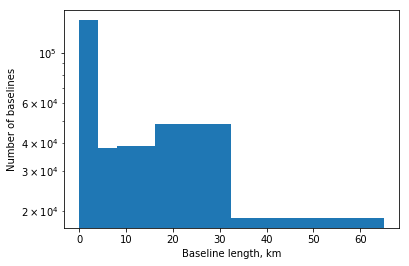

Bin upper edges: [ 4062.5  8125.  16250.  32500.  65000. ]
Percentage baselines per bin: [49.3626883  13.32914111 13.65062318 17.10107961  6.5564678 ]


In [4]:
layout = 'LOW_LONG_LAT_ECP.wgs84.753x4.txt'
layout_file = os.path.join('..', 'data', 'layouts', layout)
baseline_bins = np.array((0.0, 65.0/16.0, 65.0/8.0, 65.0/4.0, 65.0/2.0, 65.0))
baseline_distribution(layout_file, bins=baseline_bins)

## Baseline distribution for Mid

File used for layout: ../data/layouts/Rebaselined_15July2015_SKA-SA.wgs84.197x4.txt
Number of positions: 197
Longitude of array centre: 21.41099925
Latitude of array centre: -30.7215721
Number of baselines: 19306
Number of bins used: 12


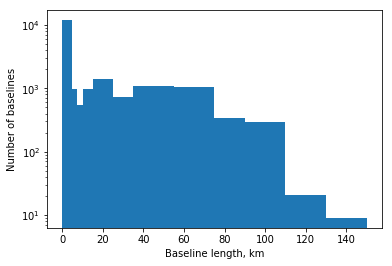

Bin upper edges: [  5000.   7500.  10000.  15000.  25000.  35000.  55000.  75000.  90000.
 110000. 130000. 150000.]
Percentage baselines per bin: [6.14890420e+01 5.06191389e+00 2.83923113e+00 5.08781928e+00
 7.13952645e+00 3.75628206e+00 5.73545412e+00 5.48158127e+00
 1.73566136e+00 1.51805606e+00 1.08802653e-01 4.66297083e-02]


In [5]:
layout = 'Rebaselined_15July2015_SKA-SA.wgs84.197x4.txt'
layout_file = os.path.join('..', 'data', 'layouts', layout)
baseline_bins = np.array((0.0, 5.0, 7.5, 10.0, 15.0, 25.0, 35.0, 55.0, 75.0, 90.0, 110.0, 130.0, 150.0))
baseline_distribution(layout_file, bins=baseline_bins)